<a href="https://colab.research.google.com/github/villafue/Capstone_2_MovieLens/blob/main/Notebook/7_Matrix_Factorization_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7.

<a name="top"></a>
## Matrix Factorization Methods

### Table of Contents

Note: The internal links work in Google Colab.

1. **[Preface](https://colab.research.google.com/github/villafue/Capstone_2_MovieLens/blob/main/MovieLens.ipynb#preface)**
2. **[Introduction](https://colab.research.google.com/github/villafue/Capstone_2_MovieLens/blob/main/MovieLens.ipynb#introduction)**
3. **[Exploratory Data Analysis](https://colab.research.google.com/github/villafue/Capstone_2_MovieLens/blob/main/Notebook/3_Exploratory_Data_Analysis.ipynb.ipynb#eda)**
4. **[Framework](https://colab.research.google.com/github/villafue/Capstone_2_MovieLens/blob/main/Notebook/4_Framework.ipynb#framework)**
5. **[Content Based Recommenders](https://colab.research.google.com/github/villafue/Capstone_2_MovieLens/blob/main/Notebook/5_Content_Based_Recommenders.ipynb#content)**
6. **[Collaborative Based Recommenders](https://colab.research.google.com/github/villafue/Capstone_2_MovieLens/blob/main/Notebook/6_Collaborative_Based_Recommenders.ipynb#collaborative)**
7. **[Matrix Factorization Methods](#matrix)**
    - 7.1 - [Introduction](#introduction)
    - 7.2 - [Import Files](#import)
    - 7.3 - [Models](#models)
      - 7.3.1 - [SVD](#svd)
      - 7.3.2 - [SVD++](#plusplus)
    - 7.4 - [Results](#results)

***

<a name="introduction"></a>
### 7.1 - Introduction

The recommendations from my KNN collaborative-based approach were awful. Frank said that one of the issues is that collaborative filtering is sensitive to noisy and sparse data. An example of that is illustrated below:

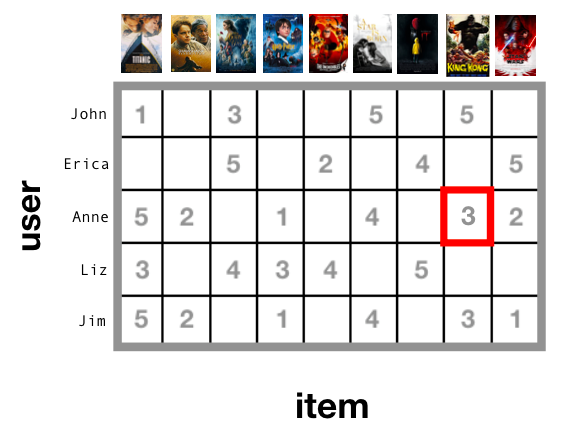

All the users are rows and all the items are movies a user could have rated. Note the blank squares as no user rated all the movies. This lack of data is known as "sparsity" and it is a real world issue that confounds recommendation systems. This is because most collaborative-based algorithms interpret "no rating" as a rating of zero, and collectively, all those zeroes would negatively affect the model. In the MovieLens example, a rating of zero would mean the user absolutely hated a movie instead of the truth that the user did not care to rate it. It's no wonder my top 10 recommendations were movies I would not want to watch.

There have been a few "tricks" to combat this data sparsity issue. One was imputing a missing value with the mean of the item (column) or the mean rating of the user (row). This helped but machine learning algorithms was soon used on the problem and it tended to give more accurate results. One of these approaches is known as Singular Value Decomposition (SVD) and a good resource for learning about it is [here](https://analyticsindiamag.com/singular-value-decomposition-svd-application-recommender-system/). SVD essentially uses [matrix factorization](https://en.wikipedia.org/wiki/Matrix_factorization_(recommender_systems) to fill in the missing ratings. It's very popular and a variant of SVD known as SVD++ was part of the final algorithm to win the [Netflix prize](https://en.wikipedia.org/wiki/Netflix_Prize).

In this notebook, I will be using both SVD and SVD++ algorithms to create recommender systems.  

***

**[Back to Top](#top)**

***

<a name="import"></a>
### 7.2 - Import Files

In [3]:
import os
os.mkdir('/content/matrix')
print('Folder created!')
os.chdir('/content/matrix')
print('Folder ready for upload!')

Folder created!
Folder ready for upload!


In [2]:
pip install scikit-surprise

     |████████████████████████████████| 11.8MB 4.9MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617528 sha256=892aff0759d89845fd02dff8273b804cf008bb733f6842bd50a9be839e43057c
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [4]:
print("Loading Framework...")
!python "MovieLens.py"
print('1 of 5: Done')
!python "RecommenderMetrics.py"
print('2 of 5: Done')
!python "EvaluationData.py"
print('3 of 5: Done')
!python "EvaluatedAlgorithm.py"
print('4 of 5: Done')
!python "Evaluator.py"
print('5 of 5: Core Framework Loaded!')

Loading Framework...
1 of 5: Done
2 of 5: Done
3 of 5: Done
4 of 5: Done
5 of 5: Core Framework Loaded!


***

**[Back to Top](#top)**

***

<a name="models"></a>
### 7.3 - Models

Both SVD and SVD++ algorithms are available via [Surpriselib](https://surprise.readthedocs.io/en/stable/matrix_factorization.html). Furthermore, I performed hyperparameter tuning using SurpriseLib's [RandomizedSearchCV](https://surprise.readthedocs.io/en/stable/model_selection.html?highlight=randomized%20search#surprise.model_selection.search.RandomizedSearchCV). This was inspired, and is analogous to, [SciKit Learn's version](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

The python scripts I used are available in this [folder](https://github.com/villafue/Capstone_2_MovieLens/tree/main/Python%20Scripts/MatrixFactorization/MatrixFactorization).

<a name="svd"></a>
#### 7.3.1 - SVD

I chose to use RandomizedSearchCV over [GridSearchCV](https://surprise.readthedocs.io/en/stable/model_selection.html?highlight=randomized%20search#surprise.model_selection.search.RandomizedSearchCV) because I prefer to cast a wider net to find optimal hyperparameters. Performing a Grid Search is exhaustive as it will iterate over every single possible combination of hyperparameters, but the time it takes to run severely limits the "grid" I can search through. RandomizedSearchCV, on the other hand, guesses at different combinations of hyperparameters and keeps guesses through the number iterations I specify.

Below, the code starts by initializing RandomizedSearchCV. Once it runs through its iterations, it uses the best hyperparameter combination to make movie recommendations. I also initialized both an "untuned" version of SVD and `Random` for comparison.  

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Mar 14 22:35:07 2021

@author: Maribel
"""

from MovieLens import MovieLens
from surprise import SVD, SVDpp
from surprise import NormalPredictor
from Evaluator import Evaluator
from surprise.model_selection import GridSearchCV
from surprise.model_selection import RandomizedSearchCV

import random
import numpy as np

def LoadMovieLensData():
    ml = MovieLens()
    print("Loading movie ratings...")
    data = ml.loadMovieLensLatestSmall()
    print("\nComputing movie popularity ranks so we can measure novelty later...")
    rankings = ml.getPopularityRanks()
    return (ml, data, rankings)

np.random.seed(29)
random.seed(29)

# Load up common data set for the recommender algorithms
(ml, evaluationData, rankings) = LoadMovieLensData()

print("Searching for best parameters...")
#param_grid = {'n_epochs': [20, 30], 'lr_all': [0.005, 0.010],
#              'n_factors': [50, 100]}
#gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

#gs.fit(evaluationData)

param_grid = {'n_epochs': range(10, 31), 
              'lr_all': np.linspace(0.001, 0.10, 10),
              'n_factors': range(10, 100, 20),
              'reg_all': np.linspace(0.01, 0.1, 10)}

rs = RandomizedSearchCV(SVD, param_distributions=param_grid, measures=['rmse', 'mae'], 
                        cv=5, random_state=29, n_jobs = -1, n_iter=50)

rs.fit(evaluationData)

# best RMSE score
#print("Best RMSE score attained: ", gs.best_score['rmse'])
print("Best RMSE score attained: ", rs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
#print(gs.best_params['rmse'])
print(rs.best_params['rmse'])

# Construct an Evaluator to, you know, evaluate them
evaluator = Evaluator(evaluationData, rankings)

#params = gs.best_params['rmse']
#SVDtuned = SVD(n_epochs = params['n_epochs'], lr_all = params['lr_all'], n_factors = params['n_factors'])

params = rs.best_params['rmse']
SVDtuned = SVD(n_epochs = params['n_epochs'], lr_all = params['lr_all'], 
               n_factors = params['n_factors'], reg_all = params['reg_all'])
evaluator.AddAlgorithm(SVDtuned, "SVD - Tuned")

SVDUntuned = SVD()
evaluator.AddAlgorithm(SVDUntuned, "SVD - Untuned")

# Just make random recommendations
Random = NormalPredictor()
evaluator.AddAlgorithm(Random, "Random")

# Fight!
evaluator.Evaluate(True)

evaluator.SampleTopNRecs(ml)


Loading movie ratings...

Computing movie popularity ranks so we can measure novelty later...
Searching for best parameters...
Best RMSE score attained:  0.8553894737323182
{'n_epochs': 11, 'lr_all': 0.034, 'n_factors': 90, 'reg_all': 0.06000000000000001}
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating  SVD - Tuned ...
Evaluating accuracy...
Evaluating top-N with leave-one-out...
Computing hit-rate and rank metrics...
Computing recommendations with full data set...
Analyzing coverage, diversity, and novelty...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Analysis complete.
Evaluating  SVD - Untuned ...
Evaluating accuracy...
Evaluating top-N with leave-one-out...
Computing hit-rate and rank metrics...
Computing recommendations with full data set...
Analyzing coverage, diversity, and novelty...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Analysis complete.

As seen below, there is a negligible difference between the RMSE of the tuned and untuned versions of SVD. Furthermore, `Novelty` is about 4 times higher with the tuned version.

| Algorithm | RMSE | MAE | HR | cHR | ARHR | Coverage | Diversity |Novelty |  
|-|-|-|-|-|-|-|-|-|
| SVD - Tuned | 0.8665 | 0.6626 | 0.0262 | 0.0262 | 0.0076 | 0.9672 | 0.2945 | 2030.2127 |
|SVD - Untuned | 0.8825 | 0.6767 | 0.0279 | 0.0279 | 0.0101 | 0.9230 | 0.0285 | 482.2240 | 
|Random | 1.4316 | 1.1420 | 0.0148 | 0.0148 | 0.0067 | 1.0000 | 0.0486 | 841.9993 | 

```
Legend:

RMSE:      Root Mean Squared Error. Lower values mean better accuracy.
MAE:       Mean Absolute Error. Lower values mean better accuracy.
HR:        Hit Rate; how often we are able to recommend a left-out rating. Higher is better.
cHR:       Cumulative Hit Rate; hit rate, confined to ratings above a certain threshold. Higher is better.
ARHR:      Average Reciprocal Hit Rank - Hit rate that takes the ranking into account. Higher is better.
Coverage:  Ratio of users for whom recommendations above a certain threshold exist. Higher is better.
Diversity: 1-S, where S is the average similarity score between every possible pair of recommendations
           for a given user. Higher means more diverse.
Novelty:   Average popularity rank of recommended items. Higher means more novel.
```
Let's see the movie recommendations:
```
Using recommender  SVD - Tuned

We recommend:
Pulp Fiction (1994) 5
Star Wars: Episode V - The Empire Strikes Back (1980) 5
Goodfellas (1990) 5
Fight Club (1999) 5
Shawshank Redemption, The (1994) 5
Departed, The (2006) 5
Philadelphia Story, The (1940) 5
Rear Window (1954) 5
Life Is Beautiful (La Vita Ã¨ bella) (1997) 5
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) 5

--------------------

Using recommender  SVD - Untuned

We recommend:
Pulp Fiction (1994) 5
Fight Club (1999) 5
Shawshank Redemption, The (1994) 5
Wallace & Gromit: The Best of Aardman Animation (1996) 5
Philadelphia Story, The (1940) 5
Airplane! (1980) 5
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950) 5
Blade Runner (1982) 5
Wallace & Gromit: The Wrong Trousers (1993) 5
Grand Day Out with Wallace and Gromit, A (1989) 5

----------------

Using recommender  Random

We recommend:
Tommy Boy (1995) 5
Jungle Book, The (1994) 5
Independence Day (a.k.a. ID4) (1996) 5
Pete's Dragon (1977) 5
Platoon (1986) 5
Apocalypse Now (1979) 5
Star Wars: Episode VI - Return of the Jedi (1983) 5
Blues Brothers, The (1980) 5
Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922) 5
Face/Off (1997) 5
```

Personally, I'm loving the recommendations. Both the untuned and tuned versions have similar results, but I would give a slight qualitative edge to the tuned version of SVD. 

***

**[Back to Top](#top)**

***

<a name="plusplus"></a>
#### 7.3.2 - SVD++

I was having issues performing both RandomizedSearchCV and GridSearchCV with SVD++. I kept getting an error despite following the same exact template with SVD. I believe the issue stems from SurpriseLib itself. 

Because of this, I just borrowed the SVD hyperparameters and just ran the model. I also added both `Random` and an untuned version of SVD++ for comparison. 

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Thu May  3 11:11:13 2018

@author: Frank
"""

from MovieLens import MovieLens
from surprise import SVD, SVDpp
from surprise import NormalPredictor
from Evaluator import Evaluator

import random
import numpy as np

def LoadMovieLensData():
    ml = MovieLens()
    print("Loading movie ratings...")
    data = ml.loadMovieLensLatestSmall()
    print("\nComputing movie popularity ranks so we can measure novelty later...")
    rankings = ml.getPopularityRanks()
    return (ml, data, rankings)

np.random.seed(29)
random.seed(29)

# Load up common data set for the recommender algorithms
(ml, evaluationData, rankings) = LoadMovieLensData()

# Construct an Evaluator to, you know, evaluate them
evaluator = Evaluator(evaluationData, rankings)

# SVD++
SVDPlusPlusTuned = SVDpp(n_epochs=11, lr_all=0.034, n_factors=90, reg_all=0.06)
#{'n_epochs': 11, 'lr_all': 0.034, 'n_factors': 90, 'reg_all': 0.06000000000000001}
evaluator.AddAlgorithm(SVDPlusPlusTuned, "SVD++Tuned")

# SVD++ Untuned
SVDPlusPlus = SVDpp()
evaluator.AddAlgorithm(SVDPlusPlus, "SVD++Untuned")

# Just make random recommendations
Random = NormalPredictor()
evaluator.AddAlgorithm(Random, "Random")

# Fight!
evaluator.Evaluate(True)

evaluator.SampleTopNRecs(ml)


Loading movie ratings...

Computing movie popularity ranks so we can measure novelty later...
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating  SVD++Untuned ...
Evaluating accuracy...
Evaluating top-N with leave-one-out...
Computing hit-rate and rank metrics...
Computing recommendations with full data set...
Analyzing coverage, diversity, and novelty...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Analysis complete.
Evaluating  SVD++Tuned ...
Evaluating accuracy...
Evaluating top-N with leave-one-out...
Computing hit-rate and rank metrics...
Computing recommendations with full data set...
Analyzing coverage, diversity, and novelty...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Analysis complete.
Evaluating  SVD++Untuned ...
Evaluating accuracy...
Evaluating top-N with leave-one-out...
Computing hit-rate and rank metrics...
Computing recommendations with fu

Below, are the results. The tuned SVD++ model barely beats the untuned version in terms of `RMSE`. Also, the Untuned version's `Novelty` is preferable to me. 

| Algorithm | RMSE | MAE | HR | cHR | ARHR | Coverage | Diversity |Novelty |  
|-|-|-|-|-|-|-|-|-|
| SVD++Untuned | 0.8712 | 0.6676 | 0.0295 | 0.0295 | 0.0114 | 0.9148 | 0.0779 | 899.7029 | 
| SVD++Tuned | 0.8641 | 0.6629 | 0.0246 | 0.0246 | 0.0068 | 0.9607 | 0.2116 | 1674.4942 |
| Random | 1.4241 | 1.1352 | 0.0148 | 0.0148 | 0.0046 | 1.0000 | 0.0519 | 865.5364 |

```
Legend:

RMSE:      Root Mean Squared Error. Lower values mean better accuracy.
MAE:       Mean Absolute Error. Lower values mean better accuracy.
HR:        Hit Rate; how often we are able to recommend a left-out rating. Higher is better.
cHR:       Cumulative Hit Rate; hit rate, confined to ratings above a certain threshold. Higher is better.
ARHR:      Average Reciprocal Hit Rank - Hit rate that takes the ranking into account. Higher is better.
Coverage:  Ratio of users for whom recommendations above a certain threshold exist. Higher is better.
Diversity: 1-S, where S is the average similarity score between every possible pair of recommendations
           for a given user. Higher means more diverse.
Novelty:   Average popularity rank of recommended items. Higher means more novel.
```

Let's see the recommendations:


```
Using recommender  SVD++Untuned

We recommend:
Silence of the Lambs, The (1991) 5
Full Metal Jacket (1987) 5
Fight Club (1999) 5
Shawshank Redemption, The (1994) 5
Departed, The (2006) 5
Wallace & Gromit: The Best of Aardman Animation (1996) 5
My Fair Lady (1964) 5
Crumb (1994) 5
Philadelphia Story, The (1940) 5
Singin' in the Rain (1952) 5

------------------------------------

Using recommender  SVD++Tuned

We recommend:
Usual Suspects, The (1995) 5
Pulp Fiction (1994) 5
Shining, The (1980) 5
Shawshank Redemption, The (1994) 5
In the Name of the Father (1993) 5
Philadelphia Story, The (1940) 5
Rear Window (1954) 5
Casablanca (1942) 5
Seven Samurai (Shichinin no samurai) (1954) 5
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) 5

-----------------------------------

Using recommender  Random

We recommend:
Rob Roy (1995) 5
Desperado (1995) 5
Clerks (1994) 5
Tommy Boy (1995) 5
Jungle Book, The (1994) 5
Silence of the Lambs, The (1991) 5
That Thing You Do! (1996) 5
Swingers (1996) 5
Monty Python and the Holy Grail (1975) 5
Princess Bride, The (1987) 5
```

Qualitatively, both the tuned and untuned recommendations are about equal to me. 

***

**[Back to Top](#top)**

***

<a name="best"></a>
### 7.4 - Best Model

If I had to pick one model, I would choose the tuned SVD. I like the metrics although the high `Novelty` score does worry me. Its' top 10 results were my favorite even if it was just barely. 

| Algorithm | RMSE | MAE | HR | cHR | ARHR | Coverage | Diversity |Novelty |  
|-|-|-|-|-|-|-|-|-|
| SVD - Tuned | 0.8665 | 0.6626 | 0.0262 | 0.0262 | 0.0076 | 0.9672 | 0.2945 | 2030.2127 |

```
Using recommender  SVD - Tuned
 
We recommend:
Pulp Fiction (1994) 5
Star Wars: Episode V - The Empire Strikes Back (1980) 5
Goodfellas (1990) 5
Fight Club (1999) 5
Shawshank Redemption, The (1994) 5
Departed, The (2006) 5
Philadelphia Story, The (1940) 5
Rear Window (1954) 5
Life Is Beautiful (La Vita Ã¨ bella) (1997) 5
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964) 5
```

***

**[Next Section]](https://colab.research.google.com/github/villafue/Capstone_2_MovieLens/blob/main/Notebook/7_Matrix_Factorization_Methods.ipynb)**

***

**[Back to Top](#top)**

***

**[Back to Main](https://colab.research.google.com/github/villafue/Capstone_2_MovieLens/blob/main/MovieLens.ipynb)**

***